In [1]:
import os
import random
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook
from PIL import Image

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from ranger import Ranger
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchelie.loss import TemperedCrossEntropyLoss
#https://github.com/Vermeille/Torchelie
from sklearn.model_selection import train_test_split
from sklearn import metrics
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2
import seaborn as sns

import logging
logging.getLogger().setLevel(logging.INFO)


import warnings
warnings.filterwarnings('ignore')


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    logging.info(f'Running on {torch.cuda.get_device_name()}')
else:
    device = torch.device('cpu')
    logging.info('Running on a CPU')
    

INFO:root:Running on GeForce GTX 1060 6GB


In [3]:
#seed everything for reproducibility
seed = 55555

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
georges, non_georges = pd.read_csv(r"georges.csv", header=None), pd.read_csv(r"non_georges.csv", header=None)
georges['label'], non_georges['label'] = 1, 0
dataframes = [georges, non_georges]
paths = {"georges":"./georges/", "non_georges":"./non_georges/"}


In [5]:
# #download data
# for path, dataframe in zip(paths, dataframes):
#     if not os.path.exists(path):
#         os.makedirs(path)

#     for number, picture in tqdm_notebook(enumerate(dataframe[:][0])):
#         image = requests.get(picture).content
#         with open(paths[path] + str(number) + ".jpg", 'wb') as f:
#             f.write(image)


In [6]:
#replace image links with local paths in both dataframes
for path, dataframe in zip(paths, dataframes):
    image_paths = [paths[path] + name for name in os.listdir(path)]
    dataframe[0] = image_paths
    

In [7]:
#create training, validation and test dataframes
#this implementation doesn't include generic 5-fold CV
df = pd.concat(dataframes)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=seed, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=seed, shuffle=True)


In [8]:
#hyperparameters
image_size = 350
batch_size = 20
gradient_accumulation_steps = 10
learning_rate = 0.0005
epochs = 35

label_counts = df.label.value_counts(sort = False)


In [9]:
#custom dataset class that augments data during training
#imagenet normalization is used for efficientnet fine-tuning

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        image_path, label = self.df_data[index]
        image = Image.open(image_path)
        image = np.array(image)
        if image.shape[-1] == 4: #removing alpha channel
            image = image[..., :3]
        if len(image.shape) == 2: #converting single channel image to 3 channel
            image = np.stack((image,)  *3, axis = -1)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        return image, label

#data augmentation used both for training and validation
#When and Why Test-Time Augmentation Works:
#https://arxiv.org/abs/2011.11156
transform = Compose([
            RandomResizedCrop(image_size, image_size),
            Transpose(p = 0.5),
            HorizontalFlip(p = 0.4),
            VerticalFlip(p = 0.4),
            ShiftScaleRotate(p = 0.3),
            MedianBlur(blur_limit = 7, always_apply = False, p = 0.3),
            IAAAdditiveGaussianNoise(scale = (0, 0.15 * 255), p = 0.5),
            HueSaturationValue(hue_shift_limit = 0.2, sat_shift_limit = 0.2, val_shift_limit = 0.2, p = 0.4),
            RandomBrightnessContrast(brightness_limit = (-0.1, 0.1), contrast_limit = (-0.1, 0.1), p = 0.5),
            Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225], max_pixel_value = 255.0, p = 1.0),
            CoarseDropout(p = 0.1),
            Cutout(p = 0.4),
            ToTensorV2(p = 1.0),
        ], p = 1.)

train_dataset, valid_dataset = Dataset(train_df, transforms = transform), Dataset(valid_df, transforms = transform)


In [10]:
from torch.utils.data import DataLoader, SequentialSampler
from catalyst.data.sampler import BalanceClassSampler

train_dataloader = DataLoader(
            train_dataset,
            #balanced sampler is used to minimize harmful effects of dataset not being fully balanced
            sampler=BalanceClassSampler(labels=train_df.label.values, mode="downsampling"),
            batch_size = batch_size)
valid_dataloader = DataLoader(
            valid_dataset,
            sampler = SequentialSampler(valid_dataset),
            batch_size = batch_size)


In [11]:
import timm

class Grisha_Classifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        #x = F.softmax(x, dim = 1)
        return x

net = Grisha_Classifier('tf_efficientnet_b3_ns', len(label_counts)).to(device)
#EfficientNet: https://arxiv.org/abs/1905.11946
#fine tuning the efficientnet for 2 labels output
#in this implementation, no weights are frozen
#ideally, batchnorm layers can be frozen for marginal training speed increase


In [12]:
import copy
loss_function = TemperedCrossEntropyLoss(t1=0.3, t2=1.7)
#Bi-Tempered Logistic Loss for Training Neural Nets with Noisy Data:
#https://ai.googleblog.com/2019/08/bi-tempered-logistic-loss-for-training.html
#https://github.com/google/bi-tempered-loss
#provides increase in accuracy on noisy data
#optimizer = optim.AdamW(net.parameters(), lr = learning_rate, weight_decay = 0.9, betas = (0.9, 0.999))
optimizer = Ranger(net.parameters(), lr = learning_rate, weight_decay = 0.9, betas = (0.9, 0.999))
scheduler = CosineAnnealingLR(optimizer, epochs * 0.3, learning_rate * 0.0001)
scheduler.last_epoch = epochs
scaler = GradScaler()

def training_loop(epochs = epochs, net = net):
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = 100
    
    for epoch in (range(epochs)):
        if epoch != 0 and epoch > 0.3 * epochs:
            scheduler.step()
        logging.info(f'Epoch {epoch+1}')
        train_losses, train_accuracies = train(net)        
        val_losses, val_accuracies = validate(net)        
        logging.info(f'Training accuracy:   {sum(train_accuracies)/len(train_accuracies)} | Training loss: {sum(train_losses)/len(train_losses)}')
        logging.info(f'Validation accuracy: {sum(val_accuracies)/len(val_accuracies)} | Validation loss: {sum(val_losses)/len(val_losses)}')
        
        epoch_val_loss = sum(val_losses)/len(val_losses)
        
        if best_loss > epoch_val_loss:    
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), 'best.pth')
            logging.info('saving with loss of {}'.format(epoch_val_loss), 'improved over previous {}'.format(best_loss))


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [13]:
def fwd_pass(inputs, labels, step, train = False, test = False):
    with autocast():
        outputs = net(inputs)    
        matches = [torch.argmax(i) == j for i, j in zip(outputs, labels)]        
        acc = matches.count(True)/len(matches)
        loss = loss_function(outputs, labels)
        if train:
            scaler.scale(loss).backward()
            if (step+1) % gradient_accumulation_steps == 0:
            #gradient accumulation to train with bigger effective batch size 
            #with less memory use
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
    if test: 
        return outputs, labels, loss, acc
    return acc, loss

def train(net):
    net.train()
    train_losses = []
    train_accuracies = []
    logging.info("Training")
    for step, batch in (enumerate(train_dataloader)):
        inputs = batch[0].to(device).float()
        labels = batch[1].to(device).long()    
        acc, loss = fwd_pass(inputs, labels, step, train = True, test = False)
        if (step+1) % gradient_accumulation_steps == 0:            
            logging.info(f"Step {step} of {len(train_dataloader)}, Accuracy: {sum(train_accuracies)/len(train_accuracies)}, Loss: {sum(train_losses)/len(train_losses)}")               
        train_losses.append(loss)
        train_accuracies.append(acc)
    return train_losses, train_accuracies               
                
def validate(net):    
    net.eval()
    val_losses = []
    val_accuracies = []
    logging.info("Validating")
    for step, batch in enumerate(valid_dataloader):            
        valid_inputs = batch[0].to(device).float()
        valid_labels = batch[1].to(device).long()
        with torch.no_grad():
            val_acc, val_loss =  fwd_pass(valid_inputs, valid_labels, step, train = False, test = False)        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)        
    return val_losses, val_accuracies

def test(net):
    net.eval()    
    logging.info("Testing")    
    test_losses_l = []
    test_labels_l = []
    test_outputs_l = []
    test_accuracies_l = []

    for step, batch in enumerate(test_dataloader):        
        test_inputs = batch[0].to(device).float()
        test_labels = batch[1].to(device).long()
        with torch.no_grad():
            outputs, labels, loss, acc = fwd_pass(test_inputs, test_labels, step, train = False, test = True) 
        outputs_i = torch.argmax(outputs).item()
        test_losses_l.append(loss)        
        test_outputs_l.append(int(torch.argmax(outputs).item()))
        test_labels_l.append(int(labels))
        test_accuracies_l.append(int(acc))
    
    cf_matrix = metrics.confusion_matrix(test_labels_l, test_outputs_l)
    cf_labels = ["True Negative", "False Positive", "False Negative", "True Positive"]
    cf_labels = np.asarray(cf_labels).reshape(2,2)    
    sns.heatmap(cf_matrix, annot=cf_labels, fmt="", cmap='Blues')

    matches = [torch.argmax(i) == j for i, j in zip(outputs, labels)]
    logging.info(f"Final test loss is {sum(test_losses_l)/len(test_losses_l)}")
    logging.info(f"Final test accuracy is {matches.count(True)/len(matches)}")



In [14]:
training_loop(epochs)
#number of epochs chosen is relatively large
#the best model will be saved and loaded for the final test


tep 79 of 193, Accuracy: 0.9386075949367096, Loss: 0.06320559233427048
Step 89 of 193, Accuracy: 0.9382022471910122, Loss: 0.06171111762523651
Step 99 of 193, Accuracy: 0.9393939393939404, Loss: 0.06032519042491913
Step 109 of 193, Accuracy: 0.9394495412844047, Loss: 0.06068342179059982
Step 119 of 193, Accuracy: 0.9407563025210095, Loss: 0.06024901196360588
Step 129 of 193, Accuracy: 0.9383720930232569, Loss: 0.06190548837184906
Step 139 of 193, Accuracy: 0.9402877697841738, Loss: 0.06086236238479614
Step 149 of 193, Accuracy: 0.94026845637584, Loss: 0.06149481609463692
Step 159 of 193, Accuracy: 0.9408805031446551, Loss: 0.06082320585846901
Step 169 of 193, Accuracy: 0.9405325443786994, Loss: 0.06144805997610092
Step 179 of 193, Accuracy: 0.941340782122906, Loss: 0.06100699305534363
Step 189 of 193, Accuracy: 0.9404761904761914, Loss: 0.0618680864572525
Validating
Training accuracy:   0.9406447898675887 | Training loss: 0.0617012083530426
Validation accuracy: 0.8968686868686873 | Val

In [15]:
test_transform = Compose([
            #Resize(height=350, width=350),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.),
            ToTensorV2(p=1.0),
            ], p=1.)

#no TTA for the final test as it simulates testing on pure unaugmented data
test_dataset = Dataset(valid_df, transforms = test_transform)
test_dataloader = DataLoader(
                test_dataset,
                sampler = SequentialSampler(test_dataset),
                batch_size = 1)


In [18]:
net.load_state_dict(torch.load('best.pth'))
net.eval()
logging.info("State dict loaded successfully")


INFO:root:State dict loaded successfully


Testing
Final test loss is 0.05450259894132614
Final test accuracy is 1.0


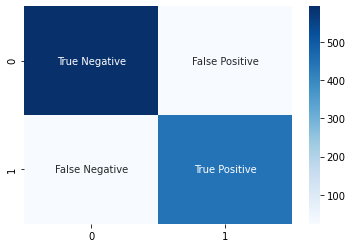

In [19]:
test(net)
